<a href="https://colab.research.google.com/github/YogaVicky/Image-Denoiser/blob/main/denoiser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
from keras import layers
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [2]:
(x_train, _), (x_test, _) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [4]:
dimension = x_train.shape[1]

In [5]:
num_data = 1000
frac_train = 0.7
frac_test = 0.3
x_train = x_train[0:int(frac_train*num_data)]
x_test = x_test[0:int(frac_test*num_data)]

In [6]:
norm_factor = 255.
x_train = x_train.astype('float32')/norm_factor
x_test = x_test.astype('float32')/norm_factor
x_train = np.reshape(x_train, (len(x_train), dimension, dimension, 1))
x_test = np.reshape(x_test, (len(x_test), dimension, dimension, 1))

In [7]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc = 0.0, scale = 1.0, size = x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc = 0.0, scale = 1.0, size = x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

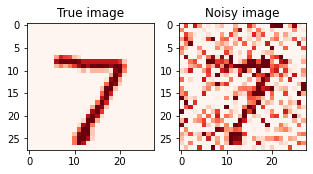

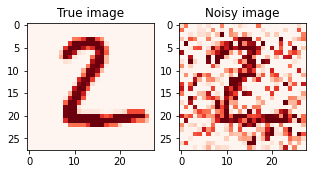

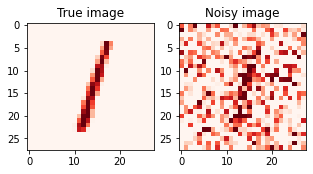

In [8]:
n = 3
for i in range(n):
    fig, axes = plt.subplots(1, 2)
    fig.set_size_inches(5, 5)
    axes[0].set_title('True image')
    im0 = axes[0].imshow(x_test[i].reshape(dimension, dimension), cmap = 'Reds')
    axes[1].set_title('Noisy image')
    im1 = axes[1].imshow(x_test_noisy[i].reshape(dimension, dimension), cmap = 'Reds')

In [9]:
input_img = keras.Input(shape = (dimension, dimension, 1))

In [10]:
x = layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same')(input_img)
x = layers.MaxPooling2D(pool_size = (2, 2), padding = 'same')(x)
x = layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x)
encoded = layers.MaxPooling2D(pool_size = (2, 2), padding = 'same')(x)

In [11]:
x = layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same')(encoded)
x = layers.UpSampling2D(size = (2, 2))(x)
x = layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x)
x = layers.UpSampling2D(size = (2, 2))(x)
decoded = layers.Conv2D(filters = 1, kernel_size = (3, 3), activation = 'sigmoid', padding = 'same')(x)

In [12]:
autoencoder = keras.Model(input_img, decoded)

In [13]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 32)          9248  

In [14]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [15]:
validation_split = 0.8
history = autoencoder.fit(x_train_noisy, x_train, epochs = 40, batch_size = 20, shuffle = True, validation_split = validation_split)

Epoch 1/40
7/7 [==============================] - 2s 138ms/step - loss: 0.5662 - val_loss: 0.5103
Epoch 2/40
7/7 [==============================] - 1s 111ms/step - loss: 0.4980 - val_loss: 0.4657
Epoch 3/40
7/7 [==============================] - 1s 110ms/step - loss: 0.4541 - val_loss: 0.4254
Epoch 4/40
7/7 [==============================] - 1s 110ms/step - loss: 0.4010 - val_loss: 0.3624
Epoch 5/40
7/7 [==============================] - 1s 112ms/step - loss: 0.3304 - val_loss: 0.2879
Epoch 6/40
7/7 [==============================] - 1s 110ms/step - loss: 0.2606 - val_loss: 0.2337
Epoch 7/40
7/7 [==============================] - 1s 110ms/step - loss: 0.2198 - val_loss: 0.2091
Epoch 8/40
7/7 [==============================] - 1s 110ms/step - loss: 0.2055 - val_loss: 0.2000
Epoch 9/40
7/7 [==============================] - 1s 111ms/step - loss: 0.1957 - val_loss: 0.1969
Epoch 10/40
7/7 [==============================] - 1s 111ms/step - loss: 0.1869 - val_loss: 0.1878
Epoch 11/40
7/7 [==

In [16]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

In [17]:
train_loss = history.history['loss']
train_val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

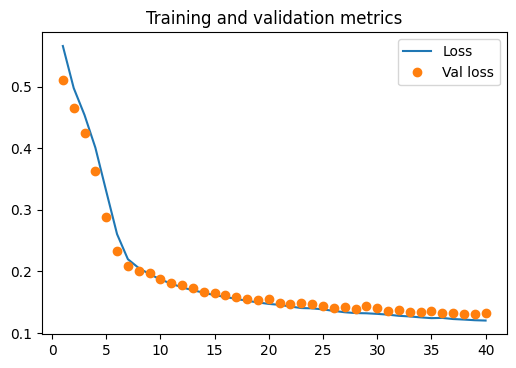

In [18]:
plt.figure(dpi = 100)
plt.plot(epochs, train_loss, label = 'Loss')
plt.plot(epochs, train_val_loss, 'o', label = 'Val loss')
plt.title('Training and validation metrics')
plt.legend()
plt.savefig('history.png')

In [19]:
all_denoised_images = autoencoder.predict(x_test_noisy)

In [20]:
test_loss  = autoencoder.evaluate(x_test_noisy, x_test, batch_size = 20)
test_loss

15/15 [==============================] - 0s 16ms/step - loss: 0.1285


0.12847693264484406

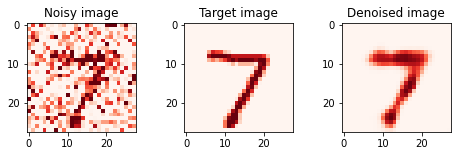

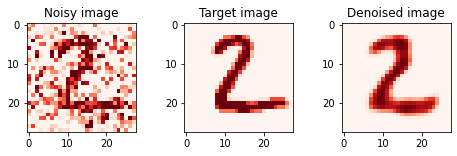

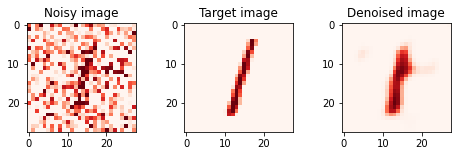

In [21]:
n = 3
for i in range(n):
    fig, axes = plt.subplots(1, 3)
    fig.set_size_inches(8, 2)
    axes[0].set_title('Noisy image')
    im0 = axes[0].imshow(x_test_noisy[i].reshape(dimension, dimension), cmap = 'Reds')
    axes[1].set_title('Target image')
    im1 = axes[1].imshow(x_test[i].reshape(dimension, dimension), cmap = 'Reds')
    axes[2].set_title('Denoised image')
    im2 = axes[2].imshow(all_denoised_images[i].reshape(dimension, dimension), cmap = 'Reds')
    plt.savefig(f'comparison-{i}.png')